# exp020_ea
exp020の誤差分析

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve
pd.set_option('display.max_rows', 100)

In [2]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [3]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [4]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [5]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [6]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [7]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [8]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [9]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [10]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

In [13]:
train = pd.read_csv('../output/exp020/train_ro_rog_sp0_kf_pm_ps.csv')

In [15]:
result = train_result(train)

In [16]:
result.err

percentile50  percentile95  p50_p90_mean
phone                                                                        
2020-05-14-US-MTV-1_Pixel4               1.193341      2.374311      1.783826
2020-05-14-US-MTV-1_Pixel4XLModded       1.074996      2.251854      1.663425
2020-05-14-US-MTV-2_Pixel4               1.635460      3.146958      2.391209
2020-05-14-US-MTV-2_Pixel4XLModded       1.744003      4.566427      3.155215
2020-05-21-US-MTV-1_Pixel4               1.771212      3.378036      2.574624
2020-05-21-US-MTV-2_Pixel4               0.629824      2.400469      1.515147
2020-05-21-US-MTV-2_Pixel4XL             0.584314      2.179024      1.381669
2020-05-29-US-MTV-1_Pixel4               2.120061      3.479443      2.799752
2020-05-29-US-MTV-1_Pixel4XL             1.901123      3.199761      2.550442
2020-05-29-US-MTV-1_Pixel4XLModded       1.757200      3.302415      2.529808
2020-05-29-US-MTV-2_Pixel4               2.297041      3.573672      2.935356
2020-05-29-US-MTV-2_Pixel4XL             2.223991      3.611792      2.917892
2020-06-04-US-MTV-1_Pixel4               1.290090      2.827714      2.058902
2020-06-04-US-MTV-1_Pixel4XL             0.772206      2.203243      1.487725
2020-06-04-US-MTV-1_Pixel4XLModded       1.650789      2.797785      2.224287
2020-06-05-US-MTV-1_Pixel4               1.121695      2.350798      1.736246
2020-06-05-US-MTV-1_Pixel4XL             1.161742      2.429271      1.795507
2020-06-05-US-MTV-1_Pixel4XLModded       1.015837      2.705710      1.860774
2020-06-05-US-MTV-2_Pixel4               0.938150      2.499907      1.719028
2020-06-05-US-MTV-2_Pixel4XL             0.880984      2.502909      1.691946
2020-06-11-US-MTV-1_Pixel4               0.928840      2.089219      1.509030
2020-06-11-US-MTV-1_Pixel4XL             0.970213      2.175446      1.572830
2020-07-08-US-MTV-1_Pixel4               1.283328      2.446629      1.864978
2020-07-08-US-MTV-1_Pixel4XL             1.199440      2.233178      1.716309
2020-07-08-US-MTV-1_Pixel4XLModded       0.948189      2.468024      1.708106
2020-07-17-US-MTV-1_Mi8                  1.721264      3.434290      2.577777
2020-07-17-US-MTV-2_Mi8                  2.868947      4.261012      3.564980
2020-08-03-US-MTV-1_Mi8                  1.554283      2.813379      2.183831
2020-08-03-US-MTV-1_Pixel4               1.680253      2.961108      2.320681
2020-08-06-US-MTV-2_Mi8                  1.652155      2.884514      2.268335
2020-08-06-US-MTV-2_Pixel4               1.103113      2.217144      1.660129
2020-08-06-US-MTV-2_Pixel4XL             1.018327      2.615220      1.816774
2020-09-04-US-SF-1_Mi8                   2.122902      3.657544      2.890223
2020-09-04-US-SF-1_Pixel4                1.848489      7.278503      4.563496
2020-09-04-US-SF-1_Pixel4XL              1.310909      2.658308      1.984609
2020-09-04-US-SF-2_Mi8                   1.553788      5.210743      3.382265
2020-09-04-US-SF-2_Pixel4                1.150643      3.886466      2.518555
2020-09-04-US-SF-2_Pixel4XL              0.824177      3.282786      2.053482
2021-01-04-US-RWC-1_Pixel4               1.066450      2.724998      1.895724
2021-01-04-US-RWC-1_Pixel4Modded         1.835231      3.831614      2.833423
2021-01-04-US-RWC-1_Pixel4XL             1.846972      5.487574      3.667273
2021-01-04-US-RWC-1_Pixel5               1.224951      2.740240      1.982595
2021-01-04-US-RWC-2_Pixel4               1.744978      3.158122      2.451550
2021-01-04-US-RWC-2_Pixel4Modded         2.047978      4.404458      3.226218
2021-01-04-US-RWC-2_Pixel4XL             2.305432      6.819202      4.562317
2021-01-04-US-RWC-2_Pixel5               1.682797      3.610861      2.646829
2021-01-05-US-SVL-1_Mi8                  1.361987      2.969114      2.165551
2021-01-05-US-SVL-1_Pixel4               1.024464      3.620245      2.322354
2021-01-05-US-SVL-1_Pixel4XL             2.571673      8.747439      5.659556
2021-01-05-US-SVL-1_Pixel5               3.211863      8.44

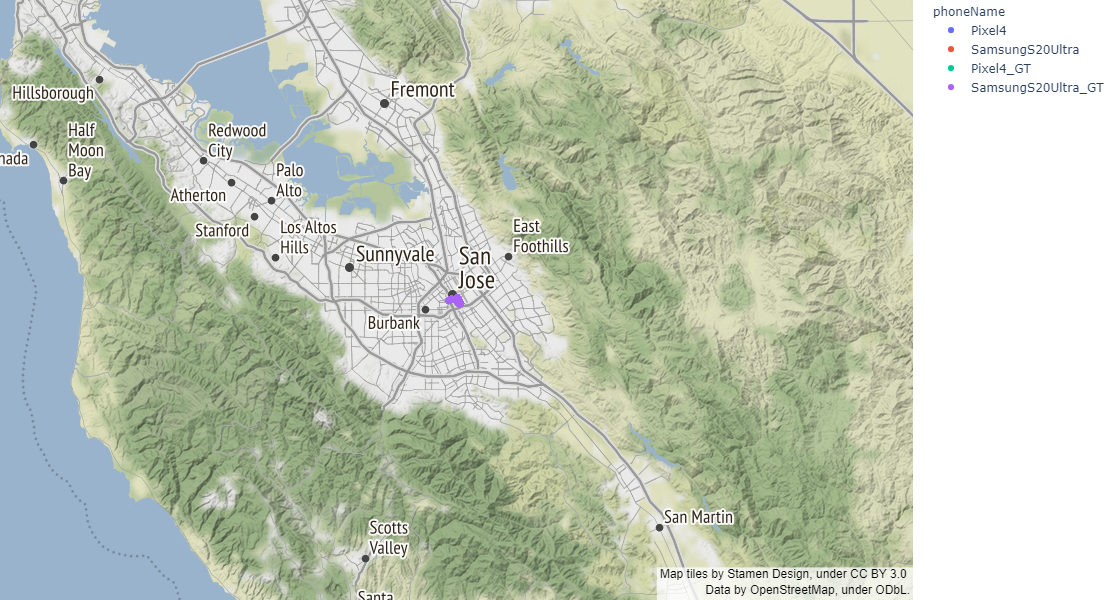

In [23]:
result.viz_map('2021-04-29-US-SJC-2', show_bl=False)

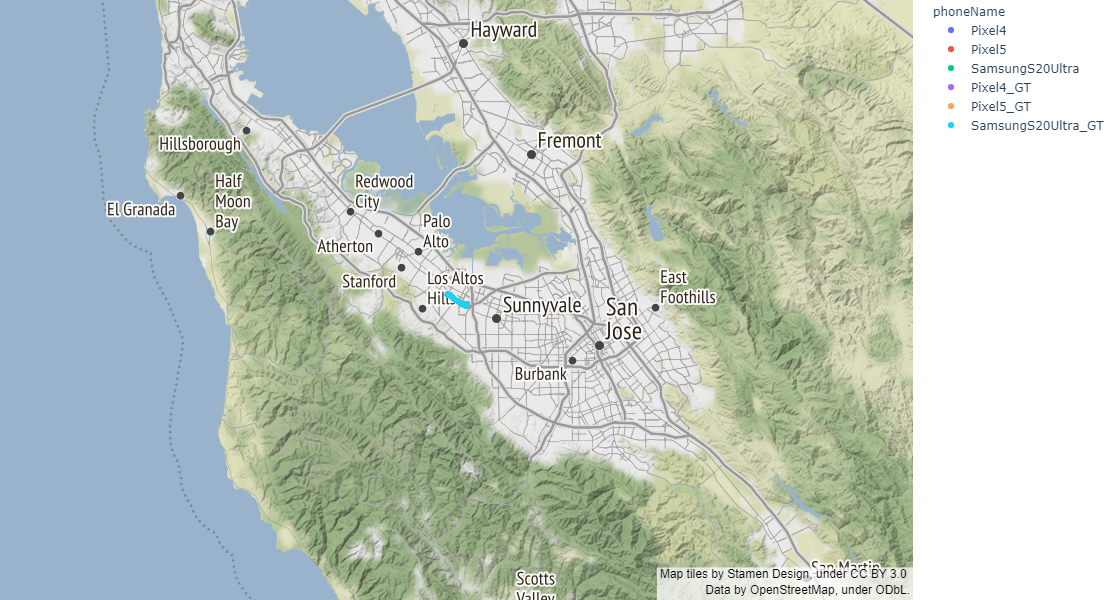

In [24]:
result.viz_map('2021-04-29-US-MTV-1', show_bl=False)